<div align="center">
  <img src="https://www.cuc.edu.co/wp-content/uploads/2024/03/logo_cuc.png" alt="Logo CUC" width="300"/>
</div>

# CUC - UNIVERSIDAD DE LA COSTA
## Departamento de Ciencias de la Computación y Electrónica
**Asignatura:** Data Mining
**Docente:** José Escorcia-Gutiérrez, Ph.D.

# **EVALUACIÓN II**
## **PROYECTO: PREDICCIÓN DE INCUMPLIMIENTO DE PRÉSTAMOS (LendingClub)**

---

### Presentado por
- **Jesús Gabriel Gudiño Lara**
- **Ana Rosa Ramírez López**

> “Las tres principales virtudes de un programador son: pereza, impaciencia y orgullo.” — *Larry Wall*

## Objetivos de aprendizaje

Al finalizar esta actividad el estudiante será capaz de:

a) Realizar **limpieza de datos**, **EDA**, **mapa de correlaciones** y **selección de variables** sobre un dataset financiero real.
b) Detectar **desbalance de clases** y aplicar **preprocesamiento**, **partición estratificada** y **técnicas de balanceo** apropiadas.
c) **Entrenar, ajustar y validar** modelos de ML utilizando **pipelines** y **optimización de hiperparámetros**.
d) **Evaluar** modelos con **Precisión, Recall, F1 por clase, Matriz de confusión y ROC-AUC**, e **interpretar sus implicaciones de negocio**.
e) **Comparar** resultados, **justificar la selección del modelo** y explicar cómo el **tuning** impacta el desempeño y la **toma de decisiones basada en riesgo**.

## Tabla de contenidos

1. [Comprensión del dataset y del contexto](#sec-1)
2. [Limpieza de datos](#sec-2)
3. [Análisis Exploratorio de Datos (EDA)](#sec-3)
4. [Selección de variables (Feature selection)](#sec-4)
5. [Preprocesamiento y partición de datos](#sec-5)
6. [Entrenamiento de modelos](#sec-6)
7. [Definición de hiperparámetros](#sec-7)
8. [Ajuste de parámetros (*tuning*)](#sec-8)
9. [Evaluación y comparación de modelos](#sec-9)

[Discusión](#sec-discuss) · [Requerimientos de entrega](#sec-submit) · [Equipo](#sec-team)

<a id="sec-1"></a>

## 1) Comprensión del dataset y del contexto
En esta seccion se
- Explora el dataset e **identifica la variable objetivo** (default vs fully paid).
- Reconoce **variables clave** (numéricas, categóricas, temporales, historial crediticio).
- Reafirma el **objetivo de negocio** y el **trade-off FP vs FN**.


- Forma del dataset: `396030 filas x 27 columnas`
- Distribución de la clase objetivo: `318357` / `77673`

- Posibles variables con **fuga de información** (si aplica): `…`

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

## 1) Comprensión del conjunto de datos y del contexto empresarial

- **Objetivo del negocio:** Predecir la probabilidad de que un préstamo sea **cargado a pérdida** (incumplido) desde su origen, con el fin de minimizar el riesgo financiero (reducir falsos positivos) sin rechazar a demasiados prestatarios confiables (reducir falsos negativos).


In [13]:
df = pd.read_csv('lending_club_loan_two.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [14]:
df.shape, df.dtypes.value_counts()

((396030, 27),
 object     15
 float64    12
 Name: count, dtype: int64)

In [25]:
df.info(), df.describe(include='all').T.iloc[:15]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  object        
 12  loan_status           396030 non-null  object        
 13 

(None,
                         count  unique                 top    freq          mean    min      25%      50%      75%        max           std
 loan_amnt            396030.0     NaN                 NaN     NaN  14113.888089  500.0   8000.0  12000.0  20000.0    40000.0   8357.441341
 term                   396030       2           36 months  302005           NaN    NaN      NaN      NaN      NaN        NaN           NaN
 int_rate             396030.0     NaN                 NaN     NaN       13.6394   5.32    10.49    13.33    16.49      30.99      4.472157
 installment          396030.0     NaN                 NaN     NaN    431.849698  16.08   250.33   375.43    567.3    1533.81     250.72779
 grade                  396030       7                   B  116018           NaN    NaN      NaN      NaN      NaN        NaN           NaN
 sub_grade              396030      35                  B3   26655           NaN    NaN      NaN      NaN      NaN        NaN           NaN
 emp_title   

In [26]:
# Objetivo: default = 1 si 'loan_status' es 'Charged Off', 0 si 'Fully Paid'
df['default'] = (df['loan_status'].str.strip().str.lower() == 'charged off').astype(int)
df['default'].value_counts()

default
0    318357
1     77673
Name: count, dtype: int64

## 2) Limpieza de datos
- Manejar valores faltantes
- Crear características útiles (por ejemplo, `term_months`, `emp_length_years`, `credit_age_years`)
- Eliminar columnas de texto con alta cardinalidad que generan ruido



### 2.1) Funciones auxiliares de limpieza y *parsing*
Definimos funciones para:
- Convertir `term` (p. ej., `"36 months"`) a número de **meses** (`term_months`).
- Convertir `emp_length` (antigüedad laboral) a **años** numéricos (`emp_length_years`).
- Parsear columnas de **fecha** a tipo `datetime` con tolerancia a formatos (`to_dt`).

In [27]:
def parse_term(term):
    """
    Convierte '36 months' -> 36.0
    Si no hay dígitos o es NaN, devuelve NaN.
    """
    if pd.isna(term):
        return np.nan
    # Extrae solo dígitos
    digits = ''.join([ch for ch in str(term) if ch.isdigit()])
    return float(digits) if digits else np.nan


def parse_emp_length(val):
    """
    Normaliza 'emp_length' a años numéricos:
      - '10+ years' -> 10.0
      - '< 1 year'  -> 0.0
      - '1 year'    -> 1.0
      - 'N years'   -> N como float
    Si no se puede parsear, devuelve NaN.
    """
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s == '10+ years':
        return 10.0
    if s == '< 1 year':
        return 0.0
    if s == '1 year':
        return 1.0
    if 'years' in s:
        try:
            return float(s.split()[0])
        except:
            return np.nan
    return np.nan


def to_dt(s):
    """
    Intenta convertir un string a datetime probando:
      1) Formato tipo '%b-%Y' (p. ej. 'Jan-2015')
      2) Parseo libre de pandas (si el anterior falla)
    Devuelve pd.NaT si no se puede convertir.
    """
    for fmt in ('%b-%Y', None):
        try:
            return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)
        except:
            continue
    return pd.NaT

### 2.2) *Feature engineering* a partir de las columnas originales
Creamos nuevas variables:
- `term_months` y `emp_length_years` usando las funciones anteriores.
- Fechas `issue_dt` y `earliest_dt` (historial más antiguo).
- **Antigüedad crediticia** en años: `credit_age_years = issue_dt - earliest_dt`.
- Descomponemos `issue_dt` en `issue_year` y `issue_month`.

In [ ]:
# Mapea campos textuales a numéricos/fechas
df['term_months'] = df['term'].map(parse_term)
df['emp_length_years'] = df['emp_length'].map(parse_emp_length)
df['issue_dt'] = df['issue_d'].apply(to_dt)
df['earliest_dt'] = df['earliest_cr_line'].apply(to_dt)

# Antigüedad crediticia (en años). OJO: si hay NaT en fechas, el resultado será NaN.
df['credit_age_years'] = ((df['issue_dt'] - df['earliest_dt']).dt.days / 365.25)

# Componentes temporales de issue_dt (año/mes). Serán NaN si issue_dt=NaT.
df['issue_year'] = df['issue_dt'].dt.year
df['issue_month'] = df['issue_dt'].dt.month

### 2.3) Depuración: eliminar columnas redundantes o ruidosas
Quitamos:
- Variables que ya **normalizamos** o **descompusimos** (`term`, `emp_length`, fechas crudas).
- Textos de **alta cardinalidad** y bajo valor predictivo directo (`title`, `emp_title`, `address`).
- `grade` si vamos a quedarnos con `sub_grade` (más granular).
- **Importante**: también retiramos `loan_status` (se usará para crear/ya creaste `default`).

In [33]:
drop_cols = [
    'loan_status',  # ya se usó/usarás para derivar 'default'
    'term', 'emp_length',
    'issue_d', 'earliest_cr_line',
    'title', 'emp_title', 'address',
    'grade'  # mantenemos 'sub_grade' por granularidad
]

# df_model será la tabla depurada para modelado
df_model = df.drop(columns=drop_cols, errors='ignore')

### 2.4) Separación de variable objetivo (y) y predictores (X)
Aquí asumimos que **`df_model['default']`** ya existe (1 = *Charged Off*, 0 = *Fully Paid*).
Si aún no la has creado, hazlo antes a partir de `loan_status`.

In [ ]:
# y = objetivo binario; X = resto de predictores
y = df_model['default'].values
X = df_model.drop(columns=['default'])

### 2.55) Identificación de tipos de variables (numéricas vs categóricas)
Esto ayuda a construir el **preprocesamiento** adecuado:
- Numéricas: imputación por **mediana** y **escalado**.
- Categóricas: imputación por **moda** y **One-Hot Encoding** (con manejo de categorías desconocidas).

In [29]:
# Listas de columnas por tipo de dato
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Columnas numéricas:', len(numeric_cols))
print('Columnas categóricas:', len(categorical_cols))

Columnas numéricas: 17
Columnas categóricas: 6


### 2.6) Descriptivos iniciales de variables numéricas
Vista rápida para detectar rangos, posibles **outliers** y valores faltantes a gran escala.
> Tip: complementa con histogramas/boxplots por variable y *countplots* en categóricas.

In [30]:
# Primeras 15 filas de la tabla de descriptivos para no saturar la salida
df_model[numeric_cols].describe().T.iloc[:15]

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.000000,8000.000000,12000.000000,20000.000000,4.000000e+04
int_rate,396030.0,13.639400,4.472157,5.320000,10.490000,13.330000,16.490000,3.099000e+01
installment,396030.0,431.849698,250.727790,16.080000,250.330000,375.430000,567.300000,1.533810e+03
annual_inc,396030.0,74203.175798,61637.621158,0.000000,45000.000000,64000.000000,90000.000000,8.706582e+06
dti,396030.0,17.379514,18.019092,0.000000,11.280000,16.910000,22.980000,9.999000e+03
open_acc,396030.0,11.311153,5.137649,0.000000,8.000000,10.000000,14.000000,9.000000e+01
pub_rec,396030.0,0.178191,0.530671,0.000000,0.000000,0.000000,0.000000,8.600000e+01
revol_bal,396030.0,15844.539853,20591.836109,0.000000,6025.000000,11181.000000,19620.000000,1.743266e+06
revol_util,395754.0,53.791749,24.452193,0.000000,35.800000,54.800000,72.900000,8.923000e+02
total_acc,396030.0,25.414744,11.886991,2.000000,17.000000,24.000000,32.000000,1.510000e+02


## 3) Análisis Exploratorio de Datos (EDA)

En esta sección:
- Revisamos forma del dataset y **balance de clases**.
- Calculamos **faltantes** por columna.
- Mostramos **estadísticos descriptivos** de variables numéricas.
- Visualizamos **distribuciones** (histogramas/boxplots).
- Calculamos **tasas de default por categoría**.
- Generamos **mapa de correlación** (numéricas) y listamos pares altamente correlacionados (potencial **multicolinealidad**).
- Explorar el balance de clases y estadísticas descriptivas

In [34]:
if 'default' not in df.columns:
    df['default'] = (df['loan_status'].astype(str).str.strip().str.lower() == 'charged off').astype(int)

# 2) Si no existe df_model, trabajamos con df (sin drops)
if 'df_model' not in globals():
    df_model = df.copy()

print("Forma (df):", df.shape, "| Forma (df_model):", df_model.shape)
print("Columnas en df_model:", len(df_model.columns))
print("Clases (default=1 / fully paid=0):\n", df['default'].value_counts())

Forma (df): (396030, 35) | Forma (df_model): (396030, 26)
Columnas en df_model: 26
Clases (default=1 / fully paid=0):
 default
0    318357
1     77673
Name: count, dtype: int64


## 3.1 Faltantes por columna
Tabla de faltantes (conteo y porcentaje) para detectar columnas problemáticas.
> Nota: Puedes usar este insumo para decidir imputaciones o exclusiones.

In [35]:
def tabla_faltantes(dataframe):
    n = len(dataframe)
    miss = dataframe.isna().sum().sort_values(ascending=False)
    pct = (miss / n).sort_values(ascending=False)
    dtypes = dataframe.dtypes
    tab = pd.DataFrame({
        'dtype': dtypes,
        'n_faltantes': miss,
        '%_faltantes': (pct * 100).round(2)
    }).sort_values('%_faltantes', ascending=False)
    return tab


print("Faltantes en df_model (top 20):")
tabla_faltantes(df_model).head(20)

Faltantes en df_model (top 20):


,dtype,n_faltantes,%_faltantes
mort_acc,float64,37795,9.54
emp_length_years,float64,18301,4.62
pub_rec_bankruptcies,float64,535,0.14
revol_util,float64,276,0.07
annual_inc,float64,0,0.00
loan_amnt,float64,0,0.00
total_acc,float64,0,0.00
term_months,float64,0,0.00
sub_grade,object,0,0.00
revol_bal,float64,0,0.00


## 3.2 Descriptivos de variables numéricas
Vista rápida de **medidas de tendencia** y **dispersión** para detectar rangos, asimetrías y posibles outliers.

In [37]:
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
desc = df_model[num_cols].describe().T
desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(3).head(15)

,mean,std,min,25%,50%,75%,max
loan_amnt,14113.888,8357.441,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,13.639,4.472,5.32,10.49,13.33,16.49,30.99
installment,431.850,250.728,16.08,250.33,375.43,567.30,1533.81
annual_inc,74203.176,61637.621,0.00,45000.00,64000.00,90000.00,8706582.00
dti,17.380,18.019,0.00,11.28,16.91,22.98,9999.00
open_acc,11.311,5.138,0.00,8.00,10.00,14.00,90.00
pub_rec,0.178,0.531,0.00,0.00,0.00,0.00,86.00
revol_bal,15844.540,20591.836,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,53.792,24.452,0.00,35.80,54.80,72.90,892.30
total_acc,25.415,11.887,2.00,17.00,24.00,32.00,151.00


## 3.3 Balance de clases (default vs fully paid)
Gráfico de barras con el conteo de **default (1)** frente a **no default (0)**.

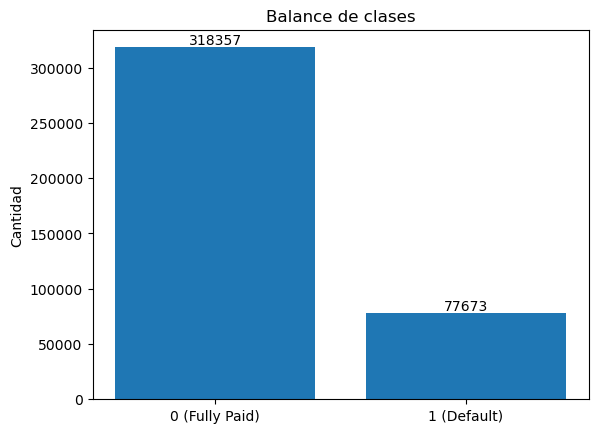

default
0    318357
1     77673
Name: count, dtype: int64

In [38]:
clase_counts = df['default'].value_counts().sort_index()
fig, ax = plt.subplots()
ax.bar(['0 (Fully Paid)', '1 (Default)'], clase_counts.values)
ax.set_title('Balance de clases')
ax.set_ylabel('Cantidad')
for i, v in enumerate(clase_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()
clase_counts

## 3.4 Distribuciones de variables numéricas
Histogramas para un subconjunto de variables numéricas típicas en el dominio.
> **Tip:** si hay fuerte asimetría (p. ej., `revol_bal`, `annual_inc`), activar `log=True` para escala logarítmica.

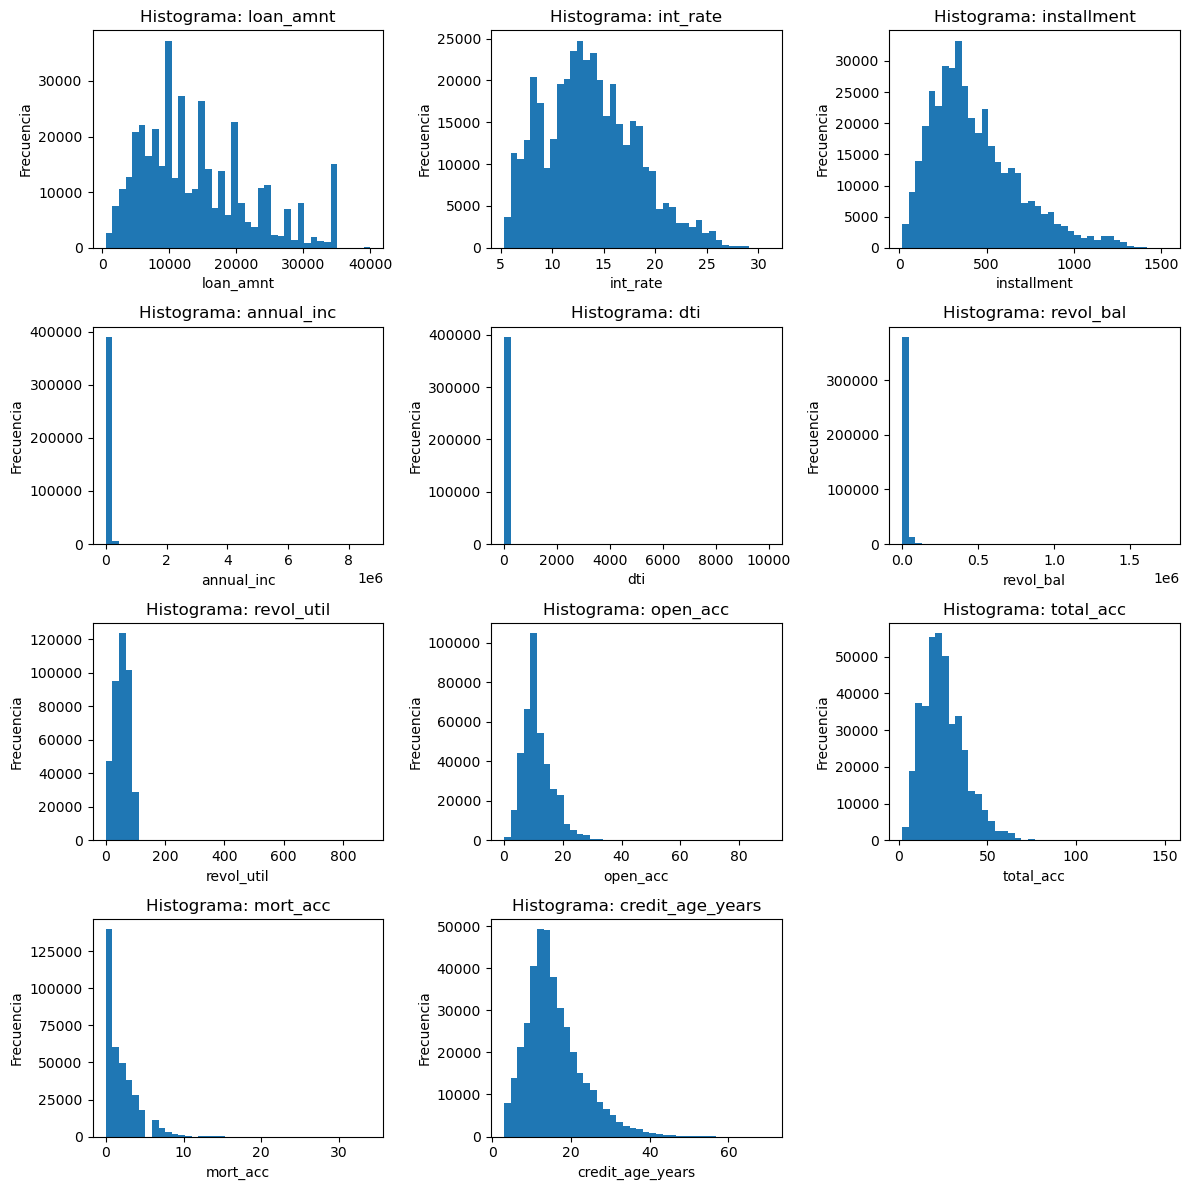

In [39]:
def plot_hist_grid(df_num, cols, bins=40, log=False, ncols=3):
    """
    Dibuja histogramas en rejilla para columnas numéricas seleccionadas.
    log=True usa escala logarítmica en eje X si todos los valores > 0.
    """
    cols = [c for c in cols if c in df_num.columns]
    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])
    for i, c in enumerate(cols):
        s = df_num[c].dropna()
        ax = axes[i]
        if log and (s > 0).all():
            ax.hist(np.log1p(s), bins=bins)
            ax.set_xlabel(f'log1p({c})')
        else:
            ax.hist(s, bins=bins)
            ax.set_xlabel(c)
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Histograma: {c}')
    # Apagar ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


cols_demo = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
    'revol_bal', 'revol_util', 'open_acc', 'total_acc', 'mort_acc',
    'credit_age_years'  # creada en feature engineering
]
plot_hist_grid(df_model, cols_demo, bins=40, log=False, ncols=3)

## 3.7 Mapa de correlación (numéricas) y multicolinealidad
- Calculamos **correlaciones** entre variables numéricas (tras **imputar** medianas para NaN).
- Mostramos un **heatmap** y listamos **pares con alta correlación absoluta** (p. ej., `|r| ≥ 0.7`).
> Estos pares podrían causar **multicolinealidad**, a tratar en *feature selection* o con regularización.

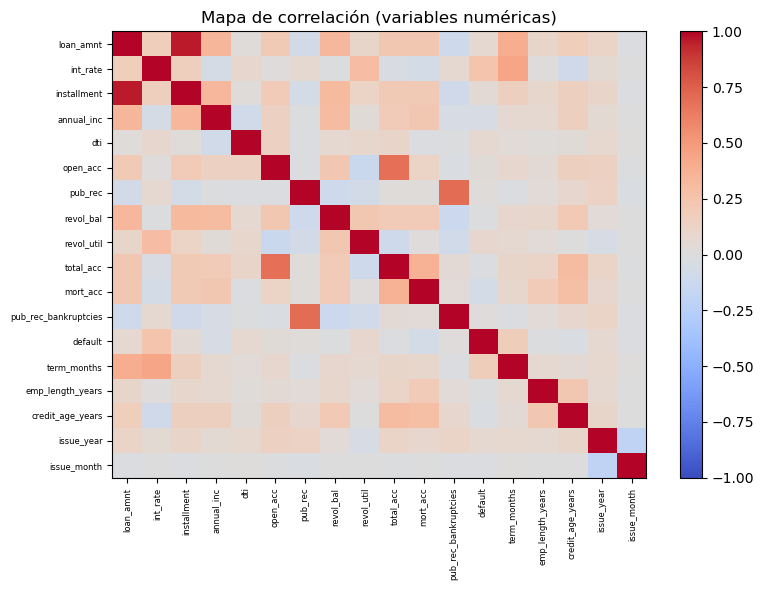

Pares con |correlación| ≥ 0.7 (si vacío, no hay pares fuertes):


,var_1,var_2,corr
0,loan_amnt,installment,0.953929


In [42]:
# Imputación temporal de medianas para correlación
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
num_df = df_model[num_cols].copy()
for c in num_cols:
    if num_df[c].isna().any():
        num_df[c] = num_df[c].fillna(num_df[c].median())

# Matriz de correlación
corr = num_df.corr(numeric_only=True)

# Heatmap simple con matplotlib
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, aspect='auto', interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Mapa de correlación (variables numéricas)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.tight_layout()
plt.show()


# Listar pares altamente correlacionados
def top_pares_correlacion(corr_mat, umbral=0.7):
    """
    Retorna tabla de pares de variables con |correlación| >= umbral.
    Evita duplicados y la diagonal.
    """
    pares = []
    cols = corr_mat.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r = corr_mat.iloc[i, j]
            if abs(r) >= umbral:
                pares.append((cols[i], cols[j], r))
    out = pd.DataFrame(pares, columns=['var_1', 'var_2', 'corr']).sort_values(by='corr', key=np.abs, ascending=False)
    return out


pares_fuertes = top_pares_correlacion(corr, umbral=0.7)
print("Pares con |correlación| ≥ 0.7 (si vacío, no hay pares fuertes):")
pares_fuertes.head(20)

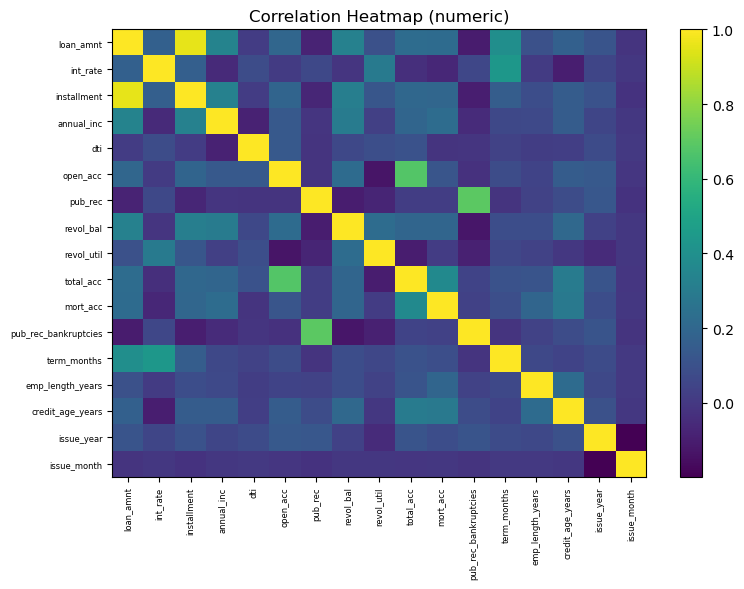

In [18]:

# Correlation heatmap (numeric only; be careful interpreting OHE features later)
num_df = X[numeric_cols].copy()
for c in num_df.columns:
    if num_df[c].isna().any():
        num_df[c] = num_df[c].fillna(num_df[c].median())
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar(); plt.title('Correlation Heatmap (numeric)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.tight_layout()
plt.show()

## 4) Selección de características
Utilizamos la **información mutua** para asignar puntuaciones a las características en relación con el objetivo y seleccionar las K principales. Esto ayuda a reducir el ruido y los efectos de multicolinealidad después de aplicar *one-hot encoding*.


In [44]:
# Preparación para selección de características con MI (Imputación simple + OHE). Calculamos MI en una muestra para velocidad.
from sklearn.preprocessing import OrdinalEncoder

# Temporal: imputar y codificar categóricas como ordinales para velocidad de MI (aproximación)
X_mi = X.copy()

# Excluye columnas datetime que causan errores de promoción de DType
datetime_cols = X_mi.select_dtypes(include=['datetime64']).columns.tolist()
if datetime_cols:
    print(f"Excluyendo columnas de tiempo del analisis {datetime_cols}")
    X_mi = X_mi.drop(columns=datetime_cols)

for c in X_mi.select_dtypes(include=[np.number]).columns:
    X_mi[c] = X_mi[c].fillna(X_mi[c].median())

cat_cols = X_mi.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_mi[cat_cols] = enc.fit_transform(X_mi[cat_cols].astype(str))

mi = mutual_info_classif(X_mi, y, discrete_features=[X_mi[c].dtype != float for c in X_mi.columns], random_state=42)
mi_series = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
mi_series.head(20)

Excluyendo columnas de tiempo del analisis ['issue_dt', 'earliest_dt']


application_type        0.060141
term_months             0.044392
sub_grade               0.038011
int_rate                0.036816
home_ownership          0.029687
verification_status     0.029220
initial_list_status     0.027210
installment             0.024933
purpose                 0.016663
emp_length_years        0.013213
loan_amnt               0.010529
dti                     0.008050
mort_acc                0.007029
issue_year              0.006391
annual_inc              0.005281
revol_util              0.003910
open_acc                0.003830
pub_rec                 0.002891
pub_rec_bankruptcies    0.002152
total_acc               0.001801
dtype: float64

In [45]:
# Escogiendo las top-K features según MI
K = min(40, X.shape[1])
top_features = mi_series.head(K).index.tolist()
top_features

['application_type',
 'term_months',
 'sub_grade',
 'int_rate',
 'home_ownership',
 'verification_status',
 'initial_list_status',
 'installment',
 'purpose',
 'emp_length_years',
 'loan_amnt',
 'dti',
 'mort_acc',
 'issue_year',
 'annual_inc',
 'revol_util',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'total_acc',
 'credit_age_years',
 'issue_month',
 'revol_bal']

## 5) Preprocesamiento y división de datos
Utilizamos un `ColumnTransformer` para los flujos de procesamiento numéricos/categóricos y conservamos únicamente las K características principales seleccionadas anteriormente. Luego realizamos una división **estratificada** entre entrenamiento y prueba.


In [21]:

X_sel = X[top_features].copy()

num_cols = X_sel.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_sel.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols),
                                  ('cat', categorical_transformer, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape, pd.Series(y_train).value_counts(normalize=True)

((316824, 23),
 (79206, 23),
 0    0.803872
 1    0.196128
 Name: proportion, dtype: float64)

## 6) Entrenamiento del modelo & 7) Hiperparámetros
Entrenamos tres modelos:
- **Regresión Logística** (modelo base, interpretable)
- **Random Forest** (no lineal, robusto)
- **HistGradientBoosting** (modelo base de boosting rápido)

Definimos los hiperparámetros clave y los ajustamos mediante **RandomizedSearchCV**.


In [ ]:
models = {
    'log_reg': LogisticRegression(max_iter=3000, class_weight='balanced', solver='lbfgs'),
    'rf': RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1),
    'hgb': HistGradientBoostingClassifier(random_state=42)
}

In [22]:
param_spaces = {
    'log_reg': {'clf__C': np.logspace(-2, 2, 12)},
    'rf': {
        'clf__n_estimators': [200, 300, 500],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2', None],
    },
    'hgb': {
        'clf__max_depth': [None, 4, 8, 12],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_iter': [100, 200, 300],
        'clf__l2_regularization': [0.0, 0.01, 0.1]
    }
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_models = {}
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    search = RandomizedSearchCV(
        pipe, param_spaces[name], n_iter=15, scoring='roc_auc',
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(name, 'best params:', search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=15. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependenc

log_reg best params: {'clf__C': 43.287612810830616}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: Reque

rf best params: {'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 30}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/M1METAL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


hgb best params: {'clf__max_iter': 300, 'clf__max_depth': 12, 'clf__learning_rate': 0.05, 'clf__l2_regularization': 0.1}


## 8) Impacto del ajuste & 9) Evaluación
Evaluamos cada modelo sobre el conjunto de prueba y comparamos **Precisión, Recall, F1 (por clase)**, **Matriz de confusión** y **ROC‑AUC**.



log_reg | ROC-AUC: 0.7112
          precision    recall  f1-score       support
0          0.888935  0.639962  0.744176  63671.000000
1          0.312994  0.672288  0.427131  15535.000000
accuracy   0.646302  0.646302  0.646302      0.646302
Confusion Matrix:
 [[40747 22924]
 [ 5091 10444]]


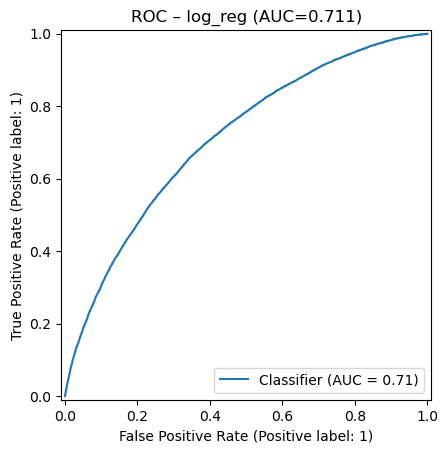


rf | ROC-AUC: 0.7254
          precision    recall  f1-score       support
0          0.852964  0.871558  0.862161  63671.000000
1          0.421927  0.384229  0.402197  15535.000000
accuracy   0.775977  0.775977  0.775977      0.775977
Confusion Matrix:
 [[55493  8178]
 [ 9566  5969]]


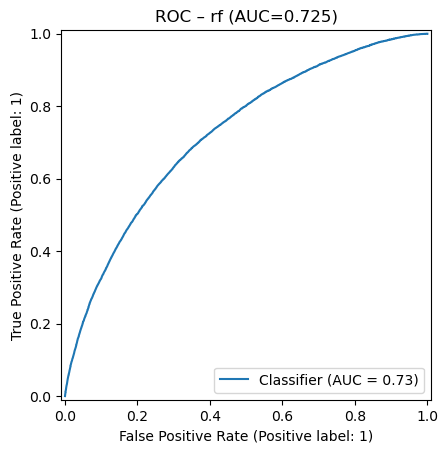


hgb | ROC-AUC: 0.7317
          precision    recall  f1-score       support
0          0.816925  0.982771  0.892206  63671.000000
1          0.579532  0.097329  0.166667  15535.000000
accuracy   0.809105  0.809105  0.809105      0.809105
Confusion Matrix:
 [[62574  1097]
 [14023  1512]]


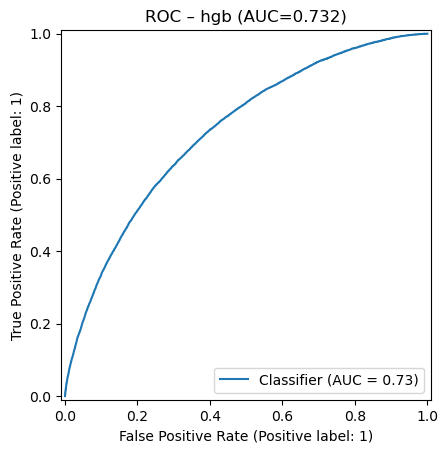

,model,roc_auc,precision_1,recall_1,f1_1
2,hgb,0.731652,0.579532,0.097329,0.166667
1,rf,0.725395,0.421927,0.384229,0.402197
0,log_reg,0.711227,0.312994,0.672288,0.427131


In [23]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = None
    rep = classification_report(y_test, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f'\n{name} | ROC-AUC: {auc:.4f}')
    print(pd.DataFrame(rep).T[['precision','recall','f1-score','support']].head(3))
    print('Confusion Matrix:\n', cm)
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC – {name} (AUC={auc:.3f})')
        plt.show()

    # Acceso más seguro a las métricas de la clase '1'
    class_1_metrics = rep.get('1', {})
    return {'model': name, 'roc_auc': auc,
            'precision_1': class_1_metrics.get('precision', 0.0),
            'recall_1': class_1_metrics.get('recall', 0.0),
            'f1_1': class_1_metrics.get('f1-score', 0.0)}

rows = []
for name, model in best_models.items():
    rows.append(evaluate_model(name, model))

pd.DataFrame(rows).sort_values('roc_auc', ascending=False)

#Discusión

## 1) Mejor equilibrio (*best balance*)
Con los resultados obtenidos:

- **AUC:** `HistGradientBoostingClassifier (0.732) ≳ RamdomForest (0.725) > LogisticRegresion(0.711)` ⇒ *HGB* y *RF* ordenan mejor por riesgo (mejor ranking global).
- **En umbral 0.5 (clase 1 = default):**
  - **LR:** *recall* **0.672** · *precision* 0.313 · **F1** **0.427**  → **detecta más morosos** (menos FN), a costa de más FP.
  - **RF:** *recall* 0.384 · *precision* 0.422 · **F1** 0.402 → compromiso intermedio (menos FP que LR, pero pierde más morosos).
  - **HGB:** *recall* 0.097 · *precision* 0.580 · **F1** 0.167 → **demasiado conservador** con umbral 0.5: casi no captura morosos.

**Implicación para LendingClub:** si la prioridad es **minimizar pérdidas por impago** (evitar **FN**), el mejor equilibrio *con umbral por defecto* lo da **Regresión Logística** (recall y F1 más altos). Si se permite **ajustar umbral**, **HGB** es un excelente **motor de *scoring*** (mejor AUC) siempre que **bajemos el umbral** para alcanzar el *recall* objetivo (p. ej., 0.60–0.70).

---


## 2) Conclusión y despliegue propuesto

**Estrategia recomendada (2 vías válidas):**

**A. *Scoring* con HGB (mejor AUC) + umbral calibrado**
- Usar **HistGradientBoostingClassifier** para puntuar riesgo.
- **Calibrar el umbral** según costo de negocio (p. ej., costo(FP) vs costo(FN)) o fijar **objetivos de *recall*** mínimos (p. ej., ≥ 0.65 en clase 1) manteniendo *precision* aceptable.
- **Calibrar probabilidades** (Platt/Isotónica) y revisar la **curva Precision–Recall**.
- Ventaja: mejor capacidad de **ordenar** solicitudes; flexible para políticas de riesgo.

**B. LR como base interpretable con umbral calibrado**
- **LR** ofrece **alto *recall*** de serie y **mejor F1** con umbral 0.5.
- Bajar o subir el umbral permite ajustar *precision–recall*; además es **explicable** (coeficientes, *odds ratios*), útil para **auditorías/regulación**.

**Operativización (ambas vías):**
- **Bandas de riesgo**:
  - `score ≥ t_alto` → **rechazo o revisión manual**.
  - `t_medio ≤ score < t_alto` → **documentación adicional / tasa más alta**.
  - `score < t_medio` → **aprobación**.
- **Monitoreo & mantenimiento**:
  - *Drift* de datos/etiquetas (PSI/KS), *recalibración de umbral* y **re-entrenamiento** periódico.
  - Panel de métricas por cohorte (mes, segmento, canal).
- **Gobernanza/explicabilidad**:
  - Si se usa HGB/RF, acompañar con **explicaciones locales** (SHAP) y una **LR auxiliar** para políticas y comunicación con negocio.

**Mensaje final:**
- **Sin ajustar umbral**, **LR** es la opción más segura para **reducir pérdidas** (alto *recall*).
- **Con ajuste de umbral**, **HGB** puede **superar** en la práctica gracias a su **AUC** mayor, al permitir fijar el punto de operación que equilibra **recall** y **precision** según el **costo de negocio**.